In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as dist
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## $x \mapsto y$

Linear Regression

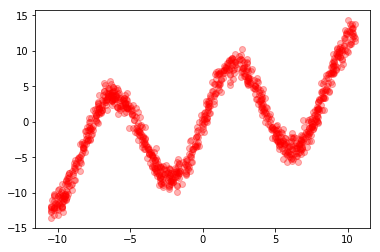

In [2]:
N = 1000

x = dist.Uniform(-10.5, 10.5).sample((N, 1))
ϵ = dist.Normal(0.0, 1.0).sample((N, 1))
y = torch.sin(0.75*x)*7.0 + 0.5*x + ϵ
plt.plot(x.cpu().numpy(), y.cpu().numpy(), 'ro', alpha=0.3)

In [3]:
batch, input_size, hidden_size, output_size = N, 1, 100, 1
model = nn.Sequential(
    nn.Linear(input_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, output_size)
)
criterion = nn.MSELoss()

In [4]:
## optimizing with first order method
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.01, alpha=0.8)
for i in range(20000):
    output = model(x)
    loss = criterion(output, y)
    if i % 1000 == 0: print(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

38.131439208984375
4.568613052368164
3.8573098182678223
3.549711227416992
3.2863025665283203
3.0988657474517822
2.844567060470581
2.7029037475585938
2.5834500789642334
2.487083911895752
2.367108106613159
2.301741600036621
2.26185941696167
2.2092525959014893
2.1618874073028564
2.0983080863952637
2.037346839904785
2.0055532455444336
1.983789086341858
1.968371033668518


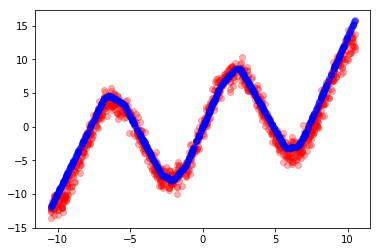

In [5]:
## test
with torch.no_grad():
    x_test = dist.Uniform(-10.5, 10.5).sample((N, 1))
    y_test = model(x_test)

plt.plot(x.cpu().numpy(), y.cpu().numpy(), "ro",
         x_test.cpu().numpy(), y_test.cpu().numpy(), "bo", alpha=.3)

## $y \mapsto x$

Mixture Density Network

In [6]:
N = 1000
y = dist.Uniform(-10.5, 10.5).sample((N, 1))
ϵ = dist.Normal(0.0, 1.0).sample((N, 1))
x = torch.sin(0.75*y)*7.0 + 0.5*y + ϵ

In [10]:
def logsumexp(x, dim=1):
    """
    Computing log sum exp along dim 1
    Input:
    x (N, ncomponent)
    Output:
    logsumexp (N, 1)
    """
    max_x, _ = x.max(dim=dim, keepdim=True)
    x = x - max_x
    return max_x + torch.log(torch.sum(torch.exp(x), dim=dim))

def logpdfGMM(log_π, μ, σ, x):
    """
    Input:
    π, μ, σ (N, ncomponent)
    x (N, 1)
    Output:
    logpdf (N, ncomponent)
    """
    log2pi = np.log(2) + np.log(np.pi)
    z = (x - μ) / σ
    exponents = log_π - 0.5*z*z - torch.log(σ) - 0.5*log2pi
    return logsumexp(exponents, dim=1)

batch, input_size, hidden_size, output_size = N, 1, 50, 1
ncomponent = 24
class MDN(nn.Module):
    """
    1-d Mixture Density Network
    """
    def __init__(self, input_size, hidden_size, ncomponent):
        super(MDN, self).__init__()
        self.linear = nn.Linear(input_size, hidden_size)
        self.f_log_π = nn.Sequential(
            nn.Linear(hidden_size, ncomponent),
            nn.LogSoftmax(dim=1)
        )
        self.f_μ = nn.Linear(hidden_size, ncomponent)
        self.f_log_σ = nn.Linear(hidden_size, ncomponent)

    def forward(self, input):
        """
        Input:
        input (batch, input_size): input[i] represents a point
        Output:
        log_π (batch, ncomponent)
        μ (batch, ncomponent)
        σ (batch, ncomponent)
        The three matrix define `batch` GMM distributions for the `batch` points
        in `input`
        """
        output = self.linear(input)
        #output = F.relu(output)
        output = torch.tanh(output)
        return self.f_log_π(output),\
               self.f_μ(output),\
               torch.exp(torch.clamp(self.f_log_σ(output), min=-10, max=10))

In [20]:
model = MDN(input_size, hidden_size, ncomponent)
optimizer = torch.optim.Adam(model.parameters())

In [21]:
for i in range(10000):
    log_π, μ, σ = model(x)
    logpdf = logpdfGMM(log_π, μ, σ, y)
    loss = -torch.mean(logpdf)
    if i % 1000 == 0: print(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

7.249392509460449
1.4122989177703857
1.2997047901153564
1.273695945739746
1.2625967264175415
1.2611191272735596
1.249232530593872
1.2540702819824219
1.2531094551086426
1.2414356470108032


In [22]:
x_test = dist.Uniform(-15, 15).sample((N, 1))
with torch.no_grad():
    log_π, μ, σ = model(x_test)
    π = torch.exp(log_π)
    #π, μ, σ = π.cpu().numpy(), μ.cpu().numpy(), σ.cpu().numpy()
    ## Sampling n samples for each GMM distribution
    #samples = map(lambda x,y,z: drawGMM(x, y, z, 5), π, μ, σ)
    ## (N, n)
    #samples = np.stack(samples)
    idxs = dist.Categorical(π).sample((1,)).t()
    samples = dist.Normal(torch.gather(μ, 1, idxs), torch.gather(σ, 1, idxs)).sample()
    samples = samples.view(-1).cpu().numpy()

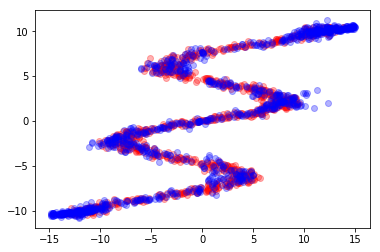

In [23]:
plt.plot(x.cpu().numpy(), y.cpu().numpy(),'ro',
         x_test.cpu().numpy(), samples, 'bo', alpha=0.3);

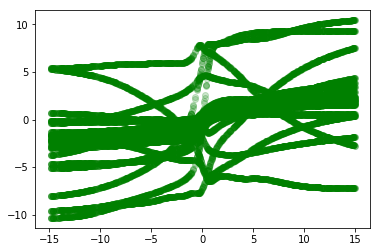

In [24]:
plt.plot(x_test.cpu().numpy(), μ.cpu().numpy(), "go", alpha=0.2);

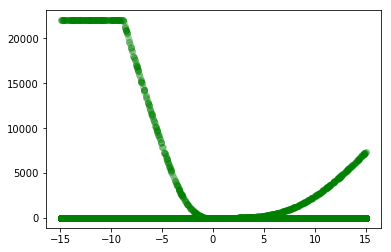

In [26]:
plt.plot(x_test.cpu().numpy(), σ.cpu().numpy(), "go", alpha=0.2);

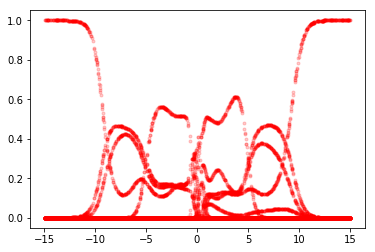

In [27]:
plt.plot(x_test.cpu().numpy(), π.cpu().numpy(), "r.", alpha=0.2);